### Task 0 Before your go

> 1. Rename Assignment-02-###.ipynb where ### is your student ID.
> 2. The deadline of Assignment-02 is 23:59pm, 04-21-2024
> 3. In this assignment, you will use word embeddings to explore our Wikipedia dataset.

### Task 1 Train word embeddings using SGNS 
> Use our enwiki-train.json as training data. You can use the [Gensim tool](https://radimrehurek.com/gensim/models/word2vec.html). But it is recommended to implement by yourself. You should explain how hyper-parameters such as dimensionality of embeddings, window size, the parameter of negative sampling strategy, and initial learning rate have been chosen.

#### 自己的模型
（跑的epoch不多，感觉效果不是很好，所以后边的任务都选择Gensim tool）

##### 第一步：数据处理

In [3]:
# Your code 
### 准备数据
import json
from collections import Counter
with open('enwiki-train.json', 'r') as file:
    train_data = file.read()

json_objects_train = train_data.strip().split('\n')
document_len = len(json_objects_train)

In [15]:
## setup dataset
import string
import nltk
all_words = []
for i in range(document_len):
    obj = json.loads(json_objects_train[i])
    text = obj.get("text")
    tt = nltk.word_tokenize(text)
    tokens = [word for word in (word.strip(string.punctuation).lower() for word in tt) if word != '']
    all_words.extend(tokens)
vocab = nltk.FreqDist(all_words)
V = len(vocab)
print("Total # of words: {}".format(len(all_words)))
print("# of unique words: {}".format(V)) 

# 文件路径
file_path = 'task1/all_word_list.json'

# 将列表保存到 JSON 文件中
with open(file_path, 'w') as f:
    json.dump(all_words, f)
    
# 读取

# # 文件路径
# file_path = 'task1/all_word_list.json'

# # 读取 JSON 文件中的列表
# with open(file_path, 'r') as f:
#     all_words = json.load(f)


Total # of words: 7461304
# of unique words: 177608


In [4]:
## 把文章按照句子分开

file = []
for i in range(document_len):
    obj = json.loads(json_objects_train[i])
    text = obj.get("text")
    sentences = nltk.sent_tokenize(text)
    for j in range(len(sentences)):
        tt = nltk.word_tokenize(sentences[j])
        words = [word for word in (word.strip(string.punctuation).lower() for word in tt) if word != '']
        file.append(words)
        
print(file[:2])

# 
file_path = 'task1/file_list.json'

# 将列表保存到 JSON 文件中
with open(file_path, 'w') as f:
    json.dump(file, f)
    
# # 文件路径
# file_path = 'task1/file_list.json'

# # 读取 JSON 文件中的列表
# with open(file_path, 'r') as f:
#     file = json.load(f)


[['citizen', 'kane', 'is', 'a', '1941', 'american', 'drama', 'film', 'produced', 'by', 'directed', 'by', 'and', 'starring', 'orson', 'welles'], ['he', 'also', 'co-wrote', 'the', 'screenplay', 'with', 'herman', 'j', 'mankiewicz']]


In [4]:
from collections import Counter    
import random
import numpy as np
## create dictionary
def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    - words: list of words
    - return: 2 dictionaries, vocab_to_int, int_to_vocab
    """
    word_counts = Counter(words)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True) # descending freq order
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

vocab_to_int, int_to_vocab = create_lookup_tables(all_words)
int_words_all = [vocab_to_int[word] for word in all_words]
print(vocab_to_int)

## 将句子转化为int
int_words = []
for i in range(len(file)):
    sentence_word = [vocab_to_int[word] for word in file[i]]
    int_words.append(sentence_word)

def get_target(words, idx, window_size=5):
    start = max(0,idx-window_size)
    end = min(idx+window_size,len(words)-1)
    targets = words[start:idx] + words[idx+1:end+1] 
    return targets

## 采用down sampling 减少高频词（如 the a an 等词）的数据量， 增加其他实词被采样到的概率
def get_batch_data(data, window_size = 5, int_words_all = int_words_all, threshold = 1e-5):
    
    word_counts = Counter(int_words_all)
    total_n_words = len(int_words_all)

    freq_ratios = {word: count/total_n_words for word, count in word_counts.items()}
    p_drop = {word: 1 - np.sqrt(threshold/freq_ratios[word]) for word in word_counts}

    input = []
    output = []
    for i in range(len(data)):
        for j in range(len(data[i])):
            if random.random() < (1 - p_drop[data[i][j]]):
                y = get_target(data[i], j, window_size=window_size)
                input.extend([data[i][j]]*len(y))
                output.extend(y)
            else:
                continue
            
    return input, output

## 将数据分为input 和 target
all_input, all_output = get_batch_data(int_words)

## 建立pair set 用于以后的在 negative sample 的时候删掉 positive 的单词对
all_pair = [(x, y) for x, y in zip(all_input, all_output)]
all_pair_set = set(all_pair)

target_dist = {}
for k in range(len(all_input)):
    if all_input[k] not in target_dist:
        target_dist[all_input[k]] = [all_output[k]]
    else:
        target_dist[all_input[k]].append(all_output[k])

{'the': 0, 'of': 1, 'and': 2, 'in': 3, 'to': 4, 'a': 5, 'was': 6, 'that': 7, 'as': 8, 's': 9, 'for': 10, 'with': 11, 'his': 12, 'is': 13, 'he': 14, 'on': 15, 'by': 16, 'it': 17, 'from': 18, 'an': 19, 'at': 20, 'be': 21, 'which': 22, 'had': 23, 'are': 24, 'or': 25, 'not': 26, 'were': 27, 'this': 28, 'but': 29, 'also': 30, 'have': 31, 'who': 32, 'film': 33, 'their': 34, 'they': 35, 'her': 36, 'one': 37, 'has': 38, 'been': 39, 'other': 40, 'its': 41, 'after': 42, 'first': 43, 'more': 44, 'would': 45, 'him': 46, 'new': 47, 'can': 48, 'when': 49, 'may': 50, 'such': 51, 'time': 52, 'all': 53, 'into': 54, 'she': 55, 'some': 56, 'most': 57, 'than': 58, 'about': 59, 'there': 60, 'during': 61, 'two': 62, 'while': 63, 'only': 64, 'i': 65, 'people': 66, 'later': 67, 'these': 68, 'used': 69, 'many': 70, 'work': 71, 'made': 72, 'between': 73, 'no': 74, 'over': 75, 'them': 76, 'years': 77, 'out': 78, 'being': 79, 'where': 80, 'life': 81, 'both': 82, 'up': 83, 'including': 84, 'war': 85, 'so': 86, 'if

In [14]:
## 建立negative sample distribution
import torch
freq_dist = Counter(int_words_all)
freq_ratio = {word:freq/len(vocab_to_int) for word, freq in freq_dist.items()}        
freq_ratio = np.array(sorted(freq_ratio.values(), reverse=True))
unigram_dist = freq_ratio / freq_ratio.sum() 
negative_dist = torch.from_numpy(unigram_dist**0.75 / np.sum(unigram_dist**0.75))

##### 第二步：建立模型

In [16]:
## define model
import torch
from torch import nn
import torch.optim as optim

class SkipGramNeg(nn.Module):
    def __init__(self, n_vocab, d_embed, negetive_dist):
        super().__init__()
        
        self.n_vocab = n_vocab
        self.d_embed = d_embed
        self.negetive_dist = negetive_dist
        
        self.in_embed = nn.Embedding(n_vocab, d_embed)
        self.out_embed = nn.Embedding(n_vocab, d_embed)
        
        # Initialize both embedding tables with uniform distribution
        self.in_embed.weight.data.uniform_(-1, 1)
        self.out_embed.weight.data.uniform_(-1, 1)
        

    def forward_input(self, input_words):
        input_vectors = self.in_embed(input_words)
        return input_vectors  
    

    def forward_target(self, output_words):
        output_vectors = self.out_embed(output_words)
        return output_vectors  
    

    def negetive_sample(self, batch_size, input_word, target_dist ,k_samples=5):
        
        negetive_words_all = torch.multinomial(input = self.negetive_dist, num_samples = len(self.negetive_dist), replacement = True)
        negetive_words = torch.tensor([])
        k = 0 # 要求的数
        m = 0 # 所有list进程
        
        while k < batch_size*k_samples:
            g = k // k_samples
            if negetive_words_all[m].item() in target_dist[int(input_word[g])]: 
                m += 1
            else:
                negetive_words = torch.cat((negetive_words, torch.tensor([negetive_words_all[m]])), dim = 0)
                m += 1
                k += 1
                                        
        negetive_vectors = self.out_embed(negetive_words.long()).view(batch_size, k_samples, self.d_embed)
        
        return negetive_vectors

In [17]:
## build loss
class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_vectors, output_vectors, negetive_vectors):
        batch_size, embed_size = input_vectors.shape
    
        input_vectors = input_vectors.reshape(batch_size, embed_size, 1)  
        output_vectors = output_vectors.reshape(batch_size, 1, embed_size) 
        # 正确的
        out_loss = torch.bmm(output_vectors, input_vectors).sigmoid().log().squeeze()
        # 错误的
        negetive_loss = torch.bmm(negetive_vectors.neg(), input_vectors).sigmoid().log()
        negetive_loss = negetive_loss.squeeze().sum(1)  

        return -(out_loss + negetive_loss).mean() # batch平均

In [18]:
## hyper-parameter
embeddings_dimension = 100
window_size = 5
negetive_sampled_k = 5
learning_rate = 1e-3
epochs = 2 # 我实际上只跑了一个epoch 时间太长了呜呜
batch_size = 250

参数选择：

embeddings_dimension: 一般来说选择50 - 300, 由于算力不足我就选择了100

window_size: 选择的一般的默认值5

negetive_sampled_k: 按照ppt所说 当数据比较多的时候选择2~5 数据比较少的时候选择5~20 所以我选择了折中的5


In [19]:
## dataset
from torch.utils.data import Dataset, DataLoader
class Dataset(Dataset):
    def __init__(self, input, output):
        self.input = input
        self.output = output
    
    def __len__(self):
        return len(self.input)
    
    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

train_dataset = Dataset(all_input, all_output)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

## define train
import torch.optim as optim

model = SkipGramNeg(len(vocab_to_int), embeddings_dimension, negetive_dist = negative_dist)
criterion = NegativeSamplingLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# 定义保存检查点函数
def save_checkpoint(epoch, model, optimizer, loss):
    checkpoint_path = f"task1/checkpoint/checkpoint_step_{epoch}_500.pth"
    torch.save({
        'step': epoch*200,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }, checkpoint_path)
    print(f"Saved checkpoint at step {epoch}_100")
    
# checkpoint = torch.load('checkpoint2_first\checkpoint_step_144_500.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# start_step = checkpoint['step'] + 1
# # start_step = 0
# loss = checkpoint['loss']

In [279]:

step = 0
for epoch in range(epochs):
    for inputs, targets in train_loader:
        step += 1
        inputs =  torch.LongTensor(inputs)   # [b*n_context_words]
        targets =  torch.LongTensor(targets)   # [b*n_context_words]
        
        embedded_input_words = model.forward_input(inputs)
        embedded_target_words = model.forward_target(targets)
        embedded_noise_words = model.negetive_sample(batch_size=inputs.shape[0], input_word=inputs, target_dist=target_dist,k_samples=negetive_sampled_k)

        loss = criterion(embedded_input_words, embedded_target_words, embedded_noise_words)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (step % 200) == 0:
            print("Epoch: {}/{}".format((epoch+1), epochs))
            print("Loss: {:.4f}".format(loss.item()))
            torch.save(model.state_dict(), 'task1/model.pth')
            # save_checkpoint((step//100), model, optimizer, loss)
        #     print("\n...\n")
        
    # print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')

Epoch: 1/2
Loss: 8.5073
Epoch: 1/2
Loss: 8.3449
Epoch: 1/2
Loss: 8.7881
Epoch: 1/2
Loss: 8.5786
Epoch: 1/2
Loss: 8.3678
Epoch: 1/2
Loss: 8.5989
Epoch: 1/2
Loss: 8.3358
Epoch: 1/2
Loss: 8.3456
Epoch: 1/2
Loss: 8.2666
Epoch: 1/2
Loss: 8.7644
Epoch: 1/2
Loss: 7.9291
Epoch: 1/2
Loss: 7.8010
Epoch: 1/2
Loss: 8.0295
Epoch: 1/2
Loss: 8.2679
Epoch: 1/2
Loss: 8.0567
Epoch: 1/2
Loss: 7.6497
Epoch: 1/2
Loss: 8.1006
Epoch: 1/2
Loss: 7.6685
Epoch: 1/2
Loss: 7.2643
Epoch: 1/2
Loss: 7.4642
Epoch: 1/2
Loss: 7.6486
Epoch: 1/2
Loss: 7.3815
Epoch: 1/2
Loss: 7.2845
Epoch: 1/2
Loss: 7.5181
Epoch: 1/2
Loss: 7.0102
Epoch: 1/2
Loss: 7.0531
Epoch: 1/2
Loss: 7.1144
Epoch: 1/2
Loss: 6.9656
Epoch: 1/2
Loss: 6.8024
Epoch: 1/2
Loss: 6.8178
Epoch: 1/2
Loss: 6.6691
Epoch: 1/2
Loss: 6.8832
Epoch: 1/2
Loss: 6.5347
Epoch: 1/2
Loss: 6.9046
Epoch: 1/2
Loss: 6.5942
Epoch: 1/2
Loss: 6.8044
Epoch: 1/2
Loss: 6.5384
Epoch: 1/2
Loss: 6.6984
Epoch: 1/2
Loss: 6.7650
Epoch: 1/2
Loss: 6.3524
Epoch: 1/2
Loss: 6.5129
Epoch: 1/2
Loss:

In [21]:
import torch
loaded_model_state_dict = torch.load('task1/model.pth')

for name, param in loaded_model_state_dict.items():
    print(name, param)

in_embed.weight tensor([[ 1.1941e-01, -1.5767e-01,  3.5738e-04,  ..., -6.7196e-02,
          1.0519e-01,  1.6075e-02],
        [-7.7407e-03, -2.8119e-01,  2.0038e-02,  ..., -1.9210e-02,
          5.9836e-02,  2.4489e-02],
        [ 5.8934e-02, -1.9297e-01,  1.1102e-01,  ..., -2.6539e-02,
          1.0213e-01,  2.1444e-02],
        ...,
        [-7.3860e-01, -2.6351e-01,  1.7388e-01,  ..., -7.5817e-02,
         -7.6435e-01,  6.7567e-01],
        [-4.9934e-01,  1.1624e-01, -7.9476e-02,  ..., -6.3437e-01,
          2.3837e-01,  5.6985e-01],
        [-2.7157e-01,  1.0722e-01, -1.6842e-01,  ...,  8.2539e-01,
         -5.7787e-01,  3.8031e-01]])
out_embed.weight tensor([[ 0.1980, -0.4671,  0.1558,  ..., -0.3131,  0.2904,  0.0624],
        [ 0.2174, -0.3430,  0.1300,  ..., -0.2590,  0.2895,  0.0650],
        [ 0.1200, -0.3994,  0.1016,  ..., -0.2446,  0.2512,  0.0880],
        ...,
        [ 0.7529, -0.3179, -0.3901,  ..., -0.0406, -0.3634, -0.1981],
        [ 0.2777, -0.8509, -0.1639,  ..., 

#### 使用Gensim tool

In [16]:
import random
import tempfile
import numpy as np  
import matplotlib.pyplot as plt

import gensim.models
from gensim import utils
from gensim.test.utils import datapath

class MyCorpus:
    """An iterator that yields sentences (lists of str)."""
    def __iter__(self, file = json_objects_train):
        for i in range(len(file)):
            obj = json.loads(file[i])
            text = obj.get("text")
            yield utils.simple_preprocess(text)

In [17]:
## hyper-parameter
embeddings_dimension = 100
window_size = 5
negetive_sampled_k = 5
learning_rate = 1e-3
epochs = 2
batch_size = 250

In [18]:
# get list of sentences
sentences = MyCorpus()
model = gensim.models.Word2Vec(sentences=sentences, vector_size=embeddings_dimension, alpha=0.025, window=window_size, 
                               min_count=5, sample=0.001, seed=1, workers=3, min_alpha=0.0001, 
                               sg=1, negative=negetive_sampled_k, ns_exponent=0.75, epochs=5, sorted_vocab=1)


save_path = "task1/gensim_model/gensim.model"
# 保存模型
model.save(save_path)

### Task 2 Find similar/dissimilar word pairs

> Randomly generate 100, 1000, and 10000-word pairs from the vocabularies. For each set, print 5 closest word pairs and 5 furthest word pairs (you can use cosine-similarity to measure two words). Explain your results.

In [19]:
from gensim.models import Word2Vec

# 加载模型
model = Word2Vec.load("task1/gensim_model/gensim.model")

In [20]:
import random

# 随机生成单词对
def generate_word_pairs(vocab, n):
    word_pairs = [(random.choice(vocab), random.choice(vocab)) for _ in range(n)]
    return word_pairs

# 打印最相似和最不相似的单词对
def print_most_and_least_similar(model, word_pairs):
    similarity_dist = {}
    for pair in word_pairs:
        word1, word2 = pair
        similarity = model.wv.similarity(word1, word2)
        similarity_dist[(word1, word2)] = similarity
        
    sorted_dist = sorted(similarity_dist.items(), key=lambda x: x[1], reverse=True)
    print("Most similar word pairs:")
    for key, value in sorted_dist[:5]:
        print(f"{key}: {value}")
    print("Most unsimilar word pairs:")
    for key, value in sorted_dist[-5:]:
        print(f"{key}: {value}")

In [21]:
# 获取词汇表
vocab = model.wv.index_to_key

# 随机生成 100、1000 和 10000 个单词对
word_pairs_100 = generate_word_pairs(vocab, 100)
word_pairs_1000 = generate_word_pairs(vocab, 1000)
word_pairs_10000 = generate_word_pairs(vocab, 10000)

print("-"*10, "100 random words pair", "-"*10, )
# 打印最相似和最不相似的单词对
print_most_and_least_similar(model, word_pairs_100)

---------- 100 random words pair ----------
Most similar word pairs:
('rankin', 'heller'): 0.8984580636024475
('foregone', 'ade'): 0.8594061732292175
('chimneys', 'tyndall'): 0.832602858543396
('unveiling', 'élysée'): 0.8027174472808838
('keepsake', 'stuttered'): 0.8008697628974915
Most unsimilar word pairs:
('myrtle', 'libertarian'): 0.1891118735074997
('observers', 'belly'): 0.1885901689529419
('isoniazid', 'built'): 0.1831095963716507
('examples', 'dirt'): 0.16067105531692505
('shrimp', 'apology'): -0.015898872166872025



Most similar word pairs:

('rankin', 'heller'): 这两个单词都是姓氏。"Rankin" 可能指代一个姓氏，而 "Heller" 可能是另一个姓氏。 所以相似度很高

('foregone', 'ade'): "Foregone" 意味着放弃或预先考虑到的，而 "ade" 可能是 "adequate" 的缩写，表示足够或适当的。可能是因为这两个单词在语义上有一定的联系

('chimneys', 'tyndall'): "Chimneys" 意为烟囱，而 "Tyndall" 可能是一个地名或姓氏。这两个单词可能在某种特定的领域或话题中经常出现在一起。

('unveiling', 'élysée'): "Unveiling" 意味着揭幕或揭露，而 "élysée" 可能是一个地名或与法国总统府相关的名称。可能是因为这两个单词在某种文化或历史背景下有关联

('keepsake', 'stuttered'): "Keepsake" 意味着纪念品或收藏品，而 "stuttered" 是 "stutter" 的过去式，表示结巴或口吃。可能是因为这两个单词在某些情境下共同出现，或者具有某种隐含的联系

Most unsimilar word pairs:

('myrtle', 'libertarian'): "Myrtle" 是一种植物，而 "libertarian" 是一个政治立场或思想，主张个人自由和限制政府权力。这两个单词在语义上可能完全不相关

('observers', 'belly'): "Observers" 意味着观察者或观察员，而 "belly" 意味着腹部或肚子。这两个单词在语义上可能完全不相关

('isoniazid', 'built'): "Isoniazid" 是一种抗结核药物，而 "built" 是 "build" 的过去式，表示建造或构建。这两个单词在语义上可能完全不相关

('examples', 'dirt'): "Examples" 意味着例子或示例，而 "dirt" 意味着污垢或尘土。这两个单词在语义上也没有明显的联系。

('shrimp', 'apology'): "Shrimp" 是一种小型海鲜动物，而 "apology" 意味着道歉或歉意。这两个单词在语义上也没有明显的联系。

In [25]:
print("-"*10, "1000 random words pair", "-"*10, )
print_most_and_least_similar(model, word_pairs_1000)

---------- 1000 random words pair ----------
Most similar word pairs:
('likeable', 'giddy'): 0.9005321860313416
('perversely', 'authentically'): 0.8957297801971436
('bowels', 'valor'): 0.890268862247467
('cloudy', 'stoppage'): 0.8872832655906677
('limerick', 'loma'): 0.8834991455078125
Most unsimilar word pairs:
('coral', 'violate'): 0.06693829596042633
('pyne', 'were'): 0.051491379737854004
('use', 'france'): 0.04681757837533951
('arabia', 'composition'): 0.026721341535449028
('curiosity', 'indonesia'): 0.014473828487098217


Most similar word pairs:

('likeable', 'giddy'): "Likeable" 意味着讨人喜欢的，而 "giddy" 意味着轻浮的或兴奋的。可能语义相近

('perversely', 'authentically'): "Perversely" 意味着故意地或错误地，而 "authentically" 意味着真实地或真正地。都是副词

('bowels', 'valor'): "Bowels" 意味着肠道或内部部分，而 "valor" 意味着勇气或英勇。

('cloudy', 'stoppage'): "Cloudy" 意味着多云的或阴天的，而 "stoppage" 意味着停顿或停止。

('limerick', 'loma'): "Limerick" 是指一种五行打油诗形式，而 "loma" 可能是某个地名或名称。可能在特定语境下经常出现

Most unsimilar word pairs:

('coral', 'violate'): "Coral" 是一种珊瑚，而 "violate" 意味着违反或侵犯。没有明显联系

('pyne', 'were'): "Pyne" 可能是一个人名或地名，而 "were" 是 "be" 的过去式，表示存在或是。

('use', 'france'): "Use" 意味着使用或利用，而 "France" 是一个国家名。没有明显联系

('arabia', 'composition'): "Arabia" 是一个地理区域名，而 "composition" 意味着组成或构成。没有明显联系

('curiosity', 'indonesia'): "Curiosity" 意味着好奇心或奇特的事物，而 "Indonesia" 是一个国家名。没有明显联系

In [26]:
print("-"*10, "10000 random words pair", "-"*10, )
print_most_and_least_similar(model, word_pairs_10000)

---------- 10000 random words pair ----------
Most similar word pairs:
('purée', 'peaches'): 0.9416012167930603
('treads', 'batons'): 0.926673173904419
('drawback', 'hurdles'): 0.9238039255142212
('parnassus', 'bearings'): 0.9230149388313293
('msh', 'hyperlipidemia'): 0.9205334186553955
Most unsimilar word pairs:
('mts', 'attracted'): -0.0074873920530080795
('meralco', 'genisys'): -0.03439367935061455
('manotoc', 'phyllo'): -0.047770820558071136
('interferon', 'countryside'): -0.11422864347696304
('chico', 'linghu'): -0.1625332087278366


最相似的单词对:

('purée', 'peaches'): "Purée" 是指果泥或浆果，而 "peaches" 意味着桃子，这两个单词可能在菜肴或食谱中共同出现。

('treads', 'batons'): "Treads" 指的是踏步或践踏，而 "batons" 意味着指挥棒或警棍，这两个单词可能与行走或警察工作有关。

('drawback', 'hurdles'): "Drawback" 意味着缺点或不利条件，而 "hurdles" 意味着障碍或困难，这两个单词可能描述类似的阻碍或挑战。

('parnassus', 'bearings'): "Parnassus" 是一个地名或文化相关的名称，而 "bearings" 意味着方向或定位，这两个单词可能在某种文学或地理背景中共同出现。

('msh', 'hyperlipidemia'): "Msh" 和 "hyperlipidemia" 都是专业术语，可能在医学领域中具有一定的关联或相似性。

最不相似的单词对:

('mts', 'attracted'): "Mts" 可能是某个地名的缩写，而 "attracted" 意味着吸引或被吸引，这两个单词在语义上没有明显联系。

('meralco', 'genisys'): "Meralco" 和 "genisys" 可能是专业术语或名称，但在语义上没有明显联系。

('manotoc', 'phyllo'): "Manotoc" 和 "phyllo" 可能是某些名称，但在语义上没有明显联系。

('interferon', 'countryside'): "Interferon" 是一种生物化学物质，而 "countryside" 意味着乡村或农村地区，这两个单词在语义上没有明显联系。

('chico', 'linghu'): "Chico" 和 "linghu" 可能是某些名称，但在语义上没有明显联系。

我们也可以发现，随着生成的单词增多，similarilty排名靠前的词越语义相近

我们也可以测试一下找一个单词的相近词

In [27]:
word = 'green'
most_similar_words = model.wv.most_similar(word, topn=5)

# 打印结果
print(f"The most similar words to '{word}':")
for similar_word, similarity in most_similar_words:
    print(f"{similar_word}: {similarity}")

The most similar words to 'green':
red: 0.7717923521995544
yellow: 0.7531756162643433
blossom: 0.7186511158943176
brown: 0.7159180641174316
cherry: 0.713711142539978


可以看出和green相近的是颜色词或者是关于植物的

In [29]:
word = 'apple'
most_similar_words = model.wv.most_similar(word, topn=5)

# 打印结果
print(f"The most similar words to '{word}':")
for similar_word, similarity in most_similar_words:
    print(f"{similar_word}: {similarity}")

The most similar words to 'apple':
acer: 0.7477599382400513
ios: 0.7301262021064758
iwork: 0.723453938961029
watchos: 0.7072520852088928
ipados: 0.7053858041763306


可以看出和apple相近的词是一些系统或者品牌，说明model由训练数据训练出apple的语义和电子产品更相近，可能是因为训练数据中有softmax这一类，而关于水果描述的比较少

### Task 3 Present a document as an embedding

> For each document, you have several choices to generate document embedding: 1. Use the average of embeddings of all words in each document; 2. Use the first paragraph’s words and take an average on these embeddings; 3. Use the doc2vec algorithm to present each document. Do the above for both training and testing dataset

In [30]:
# Your code
import json
from collections import Counter
with open('enwiki-test.json', 'r') as file:
    test_data = file.read()

json_objects_test = test_data.strip().split('\n')

#### 第一个模型

In [ ]:
## Use the average of embeddings of all words in each document
import numpy as np
import string
import nltk
all_word_mean_document_train = []
for i in range(len(json_objects_train)):
    obj = json.loads(json_objects_train[i])
    label = obj.get("label")
    text = obj.get("text")
    tt = nltk.word_tokenize(text)
    tokens = [word for word in (word.strip(string.punctuation).lower() for word in tt) if word != '']
    embeddings = []
    # 遍历单词列表，获取每个单词的嵌入向量
    for word in tokens:
        if word in model.wv:  # 确保单词在词汇表中
            embeddings.append(model.wv[word])
    
    average_embedding = np.mean(embeddings, axis=0).tolist()
    all_word_mean_document_train.append([label, average_embedding])

all_word_mean_document_test = []
for i in range(len(json_objects_test)):
    obj = json.loads(json_objects_test[i])
    label = obj.get("label")
    text = obj.get("text")
    tt = nltk.word_tokenize(text)
    tokens = [word for word in (word.strip(string.punctuation).lower() for word in tt) if word != '']
    embeddings = []
    # 遍历单词列表，获取每个单词的嵌入向量
    for word in tokens:
        if word in model.wv:  # 确保单词在词汇表中
            embeddings.append(model.wv[word])
    
    average_embedding = np.mean(embeddings, axis=0).tolist()
    all_word_mean_document_test.append([label, average_embedding])
    
# # 保存
# file_path = 'task2/all_word_mean_document_train.json'

# # 将列表保存到 JSON 文件中
# with open(file_path, 'w') as f:
#     json.dump(all_word_mean_document_train, f)

# file_path = 'task2/all_word_mean_document_test.json'

# # 将列表保存到 JSON 文件中
# with open(file_path, 'w') as f:
#     json.dump(all_word_mean_document_test, f)

#### 第二个模型

In [ ]:
# Use the first paragraph’s words and take an average on these embeddings
first_paragraph_word_mean_document_train = []
for i in range(len(json_objects_train)):
    obj = json.loads(json_objects_train[i])
    label = obj.get("label")
    text = obj.get("text")
    paragraphs = text.split('\n')
    k = 0
    while len(paragraphs[k]) == 1:
        k += 1
    tt = nltk.word_tokenize(paragraphs[k])

    tokens = [word for word in (word.strip(string.punctuation).lower() for word in tt) if word != '']
    embeddings = []
    # 遍历单词列表，获取每个单词的嵌入向量
    for word in tokens:
        if word in model.wv:  # 确保单词在词汇表中
            embeddings.append(model.wv[word])
    
    average_embedding = np.mean(embeddings, axis=0).tolist()
    first_paragraph_word_mean_document_train.append([label, average_embedding])

first_paragraph_word_mean_document_test = []
for i in range(len(json_objects_test)):
    obj = json.loads(json_objects_test[i])
    label = obj.get("label")
    text = obj.get("text")
    paragraphs = text.split('\n')
    k = 0
    while len(paragraphs[k]) == 1:
        k += 1
    tt = nltk.word_tokenize(paragraphs[k])

    tokens = [word for word in (word.strip(string.punctuation).lower() for word in tt) if word != '']
    embeddings = []
    # 遍历单词列表，获取每个单词的嵌入向量
    for word in tokens:
        if word in model.wv:  # 确保单词在词汇表中
            embeddings.append(model.wv[word])
    
    average_embedding = np.mean(embeddings, axis=0).tolist()
    first_paragraph_word_mean_document_test.append([label, average_embedding])

## 保存
# file_path = 'task2/first_paragraph_word_mean_document_train.json'

# # 将列表保存到 JSON 文件中
# with open(file_path, 'w') as f:
#     json.dump(first_paragraph_word_mean_document_train, f)

# file_path = 'task2/first_paragraph_word_mean_document_test.json'

# # 将列表保存到 JSON 文件中
# with open(file_path, 'w') as f:
#     json.dump(first_paragraph_word_mean_document_test, f)

#### 第三个模型

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import json
import gensim
from gensim import utils
from nltk import word_tokenize

class MyCorpus:
    """An iterator that yields sentences (lists of str)."""
    def __init__(self, file):
        self.file = file

    def __iter__(self):
        for i in range(len(self.file)):
            obj = json.loads(self.file[i])
            text = obj.get("text")
            # assume there's one document per line, tokens separated by whitespace
            yield TaggedDocument(words=utils.simple_preprocess(text), tags=[str(i)])
            # yield TaggedDocument(words=word_tokenize(text.lower()), tags=[str(i)]) 

# 创建 MyCorpus 类的实例
corpus_train = MyCorpus(json_objects_train)

# 初始化并训练 Doc2Vec 模型
model_train = Doc2Vec(vector_size=100, alpha=0.025, min_count=5, epochs=50, workers=4)
model_train.build_vocab(corpus_train)
model_train.train(corpus_train, total_examples=model_train.corpus_count, epochs=model_train.epochs)

# 表示每个文档
doc2vec_document_train = []
for i in range(len(json_objects_train)):
    obj = json.loads(json_objects_train[i])
    label = obj.get("label")
    doc_vector = model_train.dv[str(i)]  
    doc2vec_document_train.append([label, doc_vector.tolist()])


corpus_test = MyCorpus(json_objects_test)

model_test = Doc2Vec(vector_size=100, alpha=0.025, min_count=5, epochs=50, workers=4)
model_test.build_vocab(corpus_test)
model_test.train(corpus_test, total_examples=model_test.corpus_count, epochs=model_test.epochs)

# 表示每个文档
doc2vec_document_test = []
for i in range(len(json_objects_test)):
    obj = json.loads(json_objects_test[i])
    label = obj.get("label")
    doc_vector = model_test.dv[str(i)]  
    doc2vec_document_test.append([label, doc_vector.tolist()])
    

## 保存
# file_path = 'task2/doc2vec_document_train.json'

# # 将列表保存到 JSON 文件中
# with open(file_path, 'w') as f:
#     json.dump(doc2vec_document_train, f)

# file_path = 'task2/doc2vec_document_test.json'

# # 将列表保存到 JSON 文件中
# with open(file_path, 'w') as f:
#     json.dump(doc2vec_document_test, f)

### Task 4 Build classifier to test docs
> Build softmax regression model to classifier testing documents based on these training doc embeddings. Does it getting better than Naive Bayes'? (You have 3 models.)

#### 第一个模型

In [31]:
## first model all_word_mean_document

file_path_train = 'task2/all_word_mean_document_train.json'
# 读取 JSON 文件中的列表
with open(file_path_train, 'r') as f:
    all_word_mean_document_train = json.load(f)
    
file_path_test = 'task2/all_word_mean_document_test.json'
# 读取 JSON 文件中的列表
with open(file_path_test, 'r') as f:
    all_word_mean_document_test = json.load(f)
    
## 计算出训练对应的标签和数据
train_doc_embeddings_model1 = []
train_labels_model1 = []

for i in range(len(all_word_mean_document_train)):
    train_doc_embeddings_model1.append(all_word_mean_document_train[i][1])
    train_labels_model1.append(all_word_mean_document_train[i][0])
    
test_doc_embeddings_model1 = []
test_labels_model1 = []

for i in range(len(all_word_mean_document_test)):
    test_doc_embeddings_model1.append(all_word_mean_document_test[i][1])
    test_labels_model1.append(all_word_mean_document_test[i][0])


In [37]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

# 初始化 softmax 回归模型
softmax_model1 = LogisticRegression(multi_class='multinomial', solver='saga')

# 训练模型
softmax_model1.fit(train_doc_embeddings_model1, train_labels_model1)

# 预测测试数据
predicted_labels1 = softmax_model1.predict(test_doc_embeddings_model1)

# 计算模型准确率
accuracy = accuracy_score(test_labels_model1, predicted_labels1)
print("Model accuracy:", accuracy)


Model accuracy: 0.92


#### 第二个模型

In [32]:
## second model first_paragraph_word_mean_document_test

file_path_train = 'task2/first_paragraph_word_mean_document_train.json'
# 读取 JSON 文件中的列表
with open(file_path_train, 'r') as f:
    first_paragraph_word_mean_document_train = json.load(f)
    
file_path_test = 'task2/first_paragraph_word_mean_document_test.json'
# 读取 JSON 文件中的列表
with open(file_path_test, 'r') as f:
    first_paragraph_word_mean_document_test = json.load(f)
    
## 计算出训练对应的标签和数据
train_doc_embeddings_model2 = []
train_labels_model2 = []

for i in range(len(first_paragraph_word_mean_document_train)):
    train_doc_embeddings_model2.append(first_paragraph_word_mean_document_train[i][1])
    train_labels_model2.append(first_paragraph_word_mean_document_train[i][0])
    
test_doc_embeddings_model2 = []
test_labels_model2 = []

for i in range(len(first_paragraph_word_mean_document_test)):
    test_doc_embeddings_model2.append(first_paragraph_word_mean_document_test[i][1])
    test_labels_model2.append(first_paragraph_word_mean_document_test[i][0])


In [68]:
# 初始化 softmax 回归模型
softmax_model2 = LogisticRegression(multi_class='multinomial', solver='sag')

# 训练模型
softmax_model2.fit(train_doc_embeddings_model2, train_labels_model2)

# 预测测试数据
predicted_labels2 = softmax_model2.predict(test_doc_embeddings_model2)

# 计算模型准确率
accuracy = accuracy_score(test_labels_model2, predicted_labels2)
print("Model accuracy:", accuracy)

Model accuracy: 0.95


#### 第三个模型

In [33]:
## model3
file_path_train = 'task2/doc2vec_document_train.json'
# 读取 JSON 文件中的列表
with open(file_path_train, 'r') as f:
    doc2vec_document_train = json.load(f)

In [34]:
file_path_test = 'task2/doc2vec_document_test.json'
# 读取 JSON 文件中的列表
with open(file_path_test, 'r') as f:
    doc2vec_document_test = json.load(f)

In [35]:
    
## 计算出训练对应的标签和数据
from sklearn.calibration import LabelEncoder


train_doc_embeddings_model3 = []
train_labels_model3 = []

for i in range(len(doc2vec_document_train)):
    train_doc_embeddings_model3.append(doc2vec_document_train[i][0])
    train_labels_model3.append(doc2vec_document_train[i][1])


test_doc_embeddings_model3 = []
test_labels_model3 = []

for i in range(len(doc2vec_document_test)):
    test_doc_embeddings_model3.append(doc2vec_document_test[i][0])
    test_labels_model3.append(doc2vec_document_test[i][1])

In [38]:
# 初始化 softmax 回归模型
softmax_model3 = LogisticRegression(multi_class='multinomial', solver='saga', max_iter= 1500)

# 训练模型
softmax_model3.fit(train_doc_embeddings_model3, train_labels_model3)

# 预测测试数据
predicted_labels3 = softmax_model3.predict(test_doc_embeddings_model3)
# 计算模型准确率
accuracy = accuracy_score(test_labels_model3, predicted_labels3)
print("Model accuracy:", accuracy)

Model accuracy: 0.87


#### 对比

assignment 1建立的模型 正确率为0.93（NB） 0.95（LR）

说明建立的三个语言模型中，只有模型二到达了LR的准确率，比NB好

其他两个准确率都不如NB

### Task 5 Use t-SNE to project doc vectors

> Use t-SNE to project training document embeddings into 2d and plot them out for each of the above choices. Each point should have a specific color (represent a particular cluster). You may need to try different parameters of t-SNE. One can find more details about t-SNE in this [excellent article](https://distill.pub/2016/misread-tsne/).

为了使算法正常运行，困惑度实际上应该小于点数。
如果我们向每个聚类添加更多点，则必须增加困惑度以补偿。

In [41]:
colors = {'Film': 'red', 'Book': 'blue', 'Politician': 'green', 'Writer': 'orange', 'Food': 'purple', 
          'Actor': 'brown', 'Animal': 'pink', 'Software': 'gray', 'Artist': 'cyan', 'Disease': 'yellow'}

#### 第一个模型

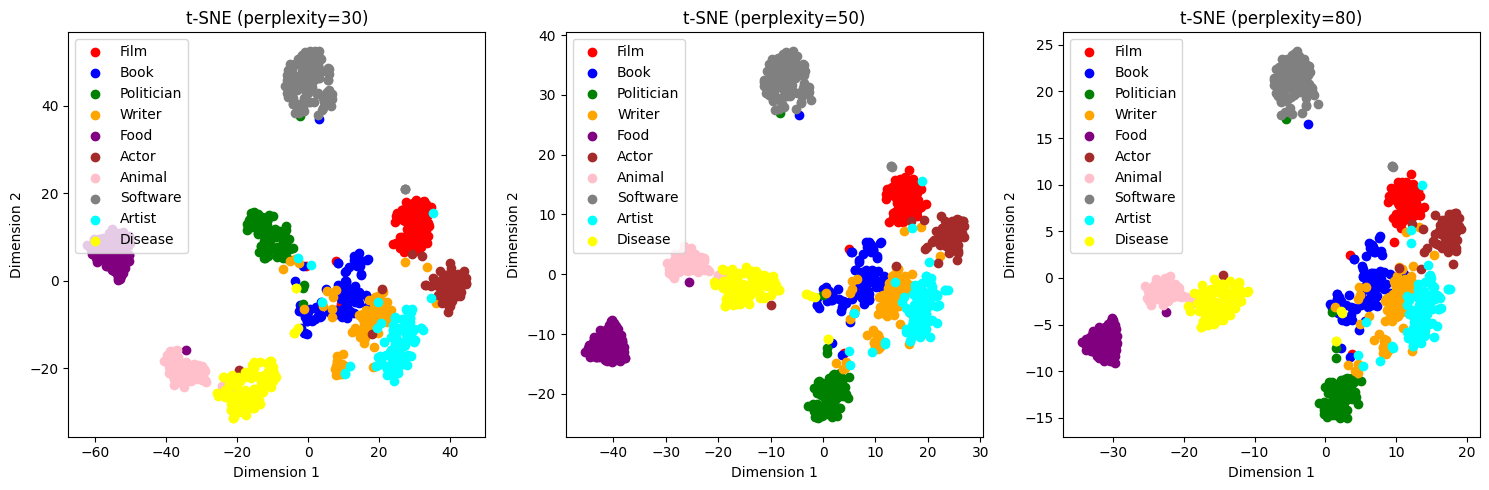

In [42]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 不同的 perplexity 值
perplexities = [30, 50, 80]

# 绘制散点图
plt.figure(figsize=(15, 5))
for i, perplexity in enumerate(perplexities):

    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=0, n_iter=1500)
    embedded_embeddings = tsne.fit_transform(np.asarray(train_doc_embeddings_model1))
    
    # 绘制子图
    plt.subplot(1, 3, i+1)
    for category, color in colors.items():
        indices = [i for i, label in enumerate(train_labels_model1) if label == category]
        plt.scatter(embedded_embeddings[indices, 0], embedded_embeddings[indices, 1], c=color, label=category)
    plt.title(f't-SNE (perplexity={perplexity})')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()

plt.tight_layout()
plt.show()


#### 第二个模型

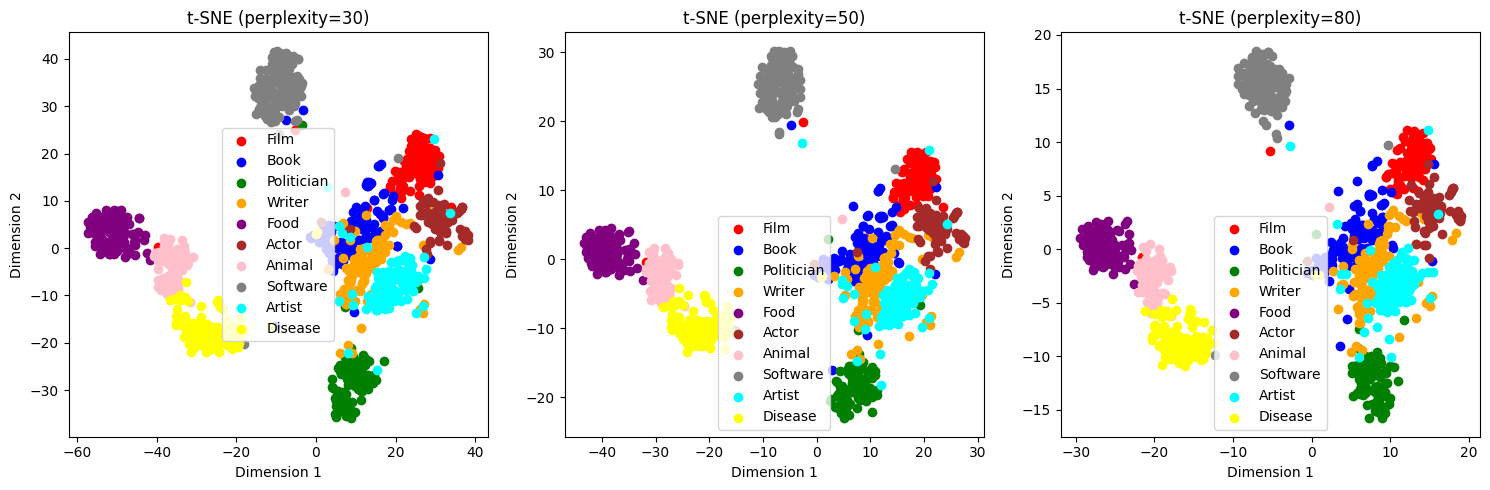

In [43]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 不同的 perplexity 值
perplexities = [30, 50, 80]

# 绘制散点图
plt.figure(figsize=(15, 5))
for i, perplexity in enumerate(perplexities):

    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=0, n_iter=1500)
    embedded_embeddings = tsne.fit_transform(np.asarray(train_doc_embeddings_model2))
    
    # 绘制子图
    plt.subplot(1, 3, i+1)
    for category, color in colors.items():
        indices = [i for i, label in enumerate(train_labels_model2) if label == category]
        plt.scatter(embedded_embeddings[indices, 0], embedded_embeddings[indices, 1], c=color, label=category)
    plt.title(f't-SNE (perplexity={perplexity})')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()

plt.tight_layout()
plt.show()


#### 第三个模型

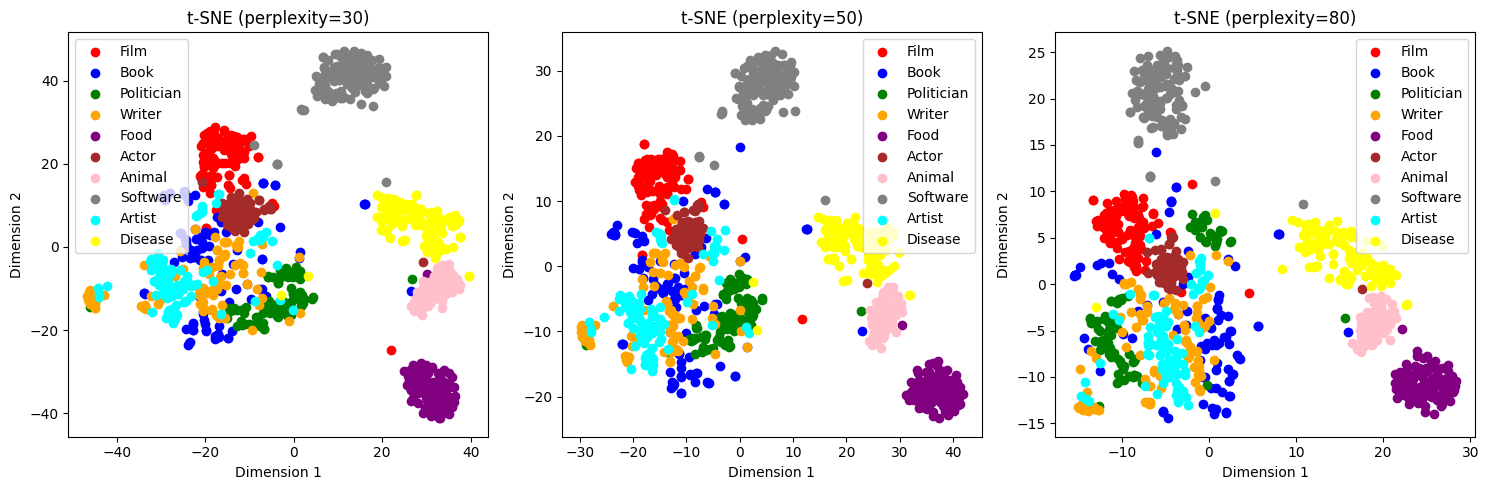

In [45]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 不同的 perplexity 值
perplexities = [30, 50, 80]

# 绘制散点图
plt.figure(figsize=(15, 5))
for i, perplexity in enumerate(perplexities):

    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=0, n_iter=1500)
    embedded_embeddings = tsne.fit_transform(np.asarray(train_doc_embeddings_model3))
    
    # 绘制子图
    plt.subplot(1, 3, i+1)
    for category, color in colors.items():
        indices = [i for i, label in enumerate(train_labels_model3) if label == category]
        plt.scatter(embedded_embeddings[indices, 0], embedded_embeddings[indices, 1], c=color, label=category)
    plt.title(f't-SNE (perplexity={perplexity})')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()

plt.tight_layout()
plt.show()


看起来果然model3的效果欠佳

从前面两个model看Writer Book Artist离的比较近 Film 和 Actor 离的比较近 说明语义比较相近 挺合理的